**Author**: Sangyoon Park

**Date**: 2020-12-18

**Objective**: This notebooks aims to grid-search `diversification strength (DIV)` $\times$ `number of auxiliary functions (AUX)` while fixing `regularization strength (REG)`.

In [ ]:
# Configure environment
from os import path
CURR_PATH = path.abspath("__file__") # Full path to current script
ROOT_PATH = path.dirname(path.dirname(CURR_PATH))
import sys; sys.path.insert(0, ROOT_PATH)

In [ ]:
import time
from src.models import LUNA
from src.utils import generate_data, format_time, neg_log_likelihood, epistemic_uncertainty

In [ ]:
from autograd import numpy as np
import matplotlib.pyplot as plt

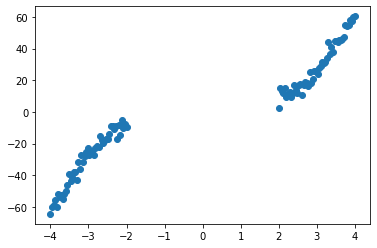

In [ ]:
# Generate toy data
x, y, x_test, y_test = generate_data(number_of_points=50, noise_variance=9)
plt.scatter(x, y)
plt.show()

# Extract test gap data
gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

# Extract test non-gap data
non_gap_idx = np.logical_and(np.logical_and(x_test > -4, x_test < 4), np.logical_not(gap_idx))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

In [ ]:
def experiment_LUNA_1D(n_aux, reg_param, lambda_in, step_size=1e-2, max_iteration=1500, x_train=x, y_train=y):
    activation_fn_type = 'relu'
    activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

    input_dim = 1
    output_dim = 1
    width = [50,50] # using the architecture used in the paper

    architecture = {
        'width': width,
        'input_dim': input_dim,
        'output_dim': output_dim,
        'activation_fn_type': 'relu',
        'activation_fn_params': 'rate=1',
        'activation_fn': activation_fn,
        'auxiliary_functions': n_aux,
    }

    params = {
        'step_size': step_size,
        'max_iteration': max_iteration,
        'random_restarts': 1,
        'reg_param': reg_param,
        'lambda_in': lambda_in,
    }

    rand_state = 207
    random = np.random.RandomState(rand_state)

    luna = LUNA(architecture, random=random)
    print("")
    print(f"===== [ Aux Functions: {n_aux} ] === [ Regularization: {reg_param} ] === [ Diversification: {lambda_in} ] =====")
    print("")
    t0 = time.time()
    luna.fit(x_train, y_train, params)
    print("")
    print("Training took {:} (h:mm:ss)".format(format_time(time.time()-t0)))

    return luna

In [ ]:
# Set hyper-parameter values to examine
reg = 600 # Fixed
aux_grid = [3, 5, 10, 30, 50]
div_grid = [0, 10, 100, 1000, 10000]

In [ ]:
# Fit LUNA
luna_list = []
for div in div_grid:
    for aux in aux_grid:
        luna = experiment_LUNA_1D(aux, reg, div, step_size=1e-2, max_iteration=5000)
        luna_list.append(luna)


===== [ Aux Functions: 3 ] === [ Regularization: 600 ] === [ Diversification: 0 ] =====

Iteration 0 loss 6897.933233729652; gradient mag: 9374.312045008528
Iteration 100 loss 411.9182708919886; gradient mag: 26.492591916868264
Iteration 200 loss 330.8533189883206; gradient mag: 18.47024865515469
Iteration 300 loss 284.79822440248967; gradient mag: 16.50168191747239
Iteration 400 loss 249.86144542733325; gradient mag: 15.250120063343891
Iteration 500 loss 220.6972137078517; gradient mag: 12.971931421767035
Iteration 600 loss 195.8093568099722; gradient mag: 12.802613509897482
Iteration 700 loss 174.13073033002144; gradient mag: 11.737450769739675
Iteration 800 loss 155.81814698443407; gradient mag: 11.036491834830892
Iteration 900 loss 140.09703031200561; gradient mag: 11.831460912344017
Iteration 1000 loss 126.5319797705318; gradient mag: 12.759377195450703
Iteration 1100 loss 114.85514951431132; gradient mag: 9.563396854217244
Iteration 1200 loss 104.77705020356316; gradient mag: 8.

## Plot auxiliary functions after fitting

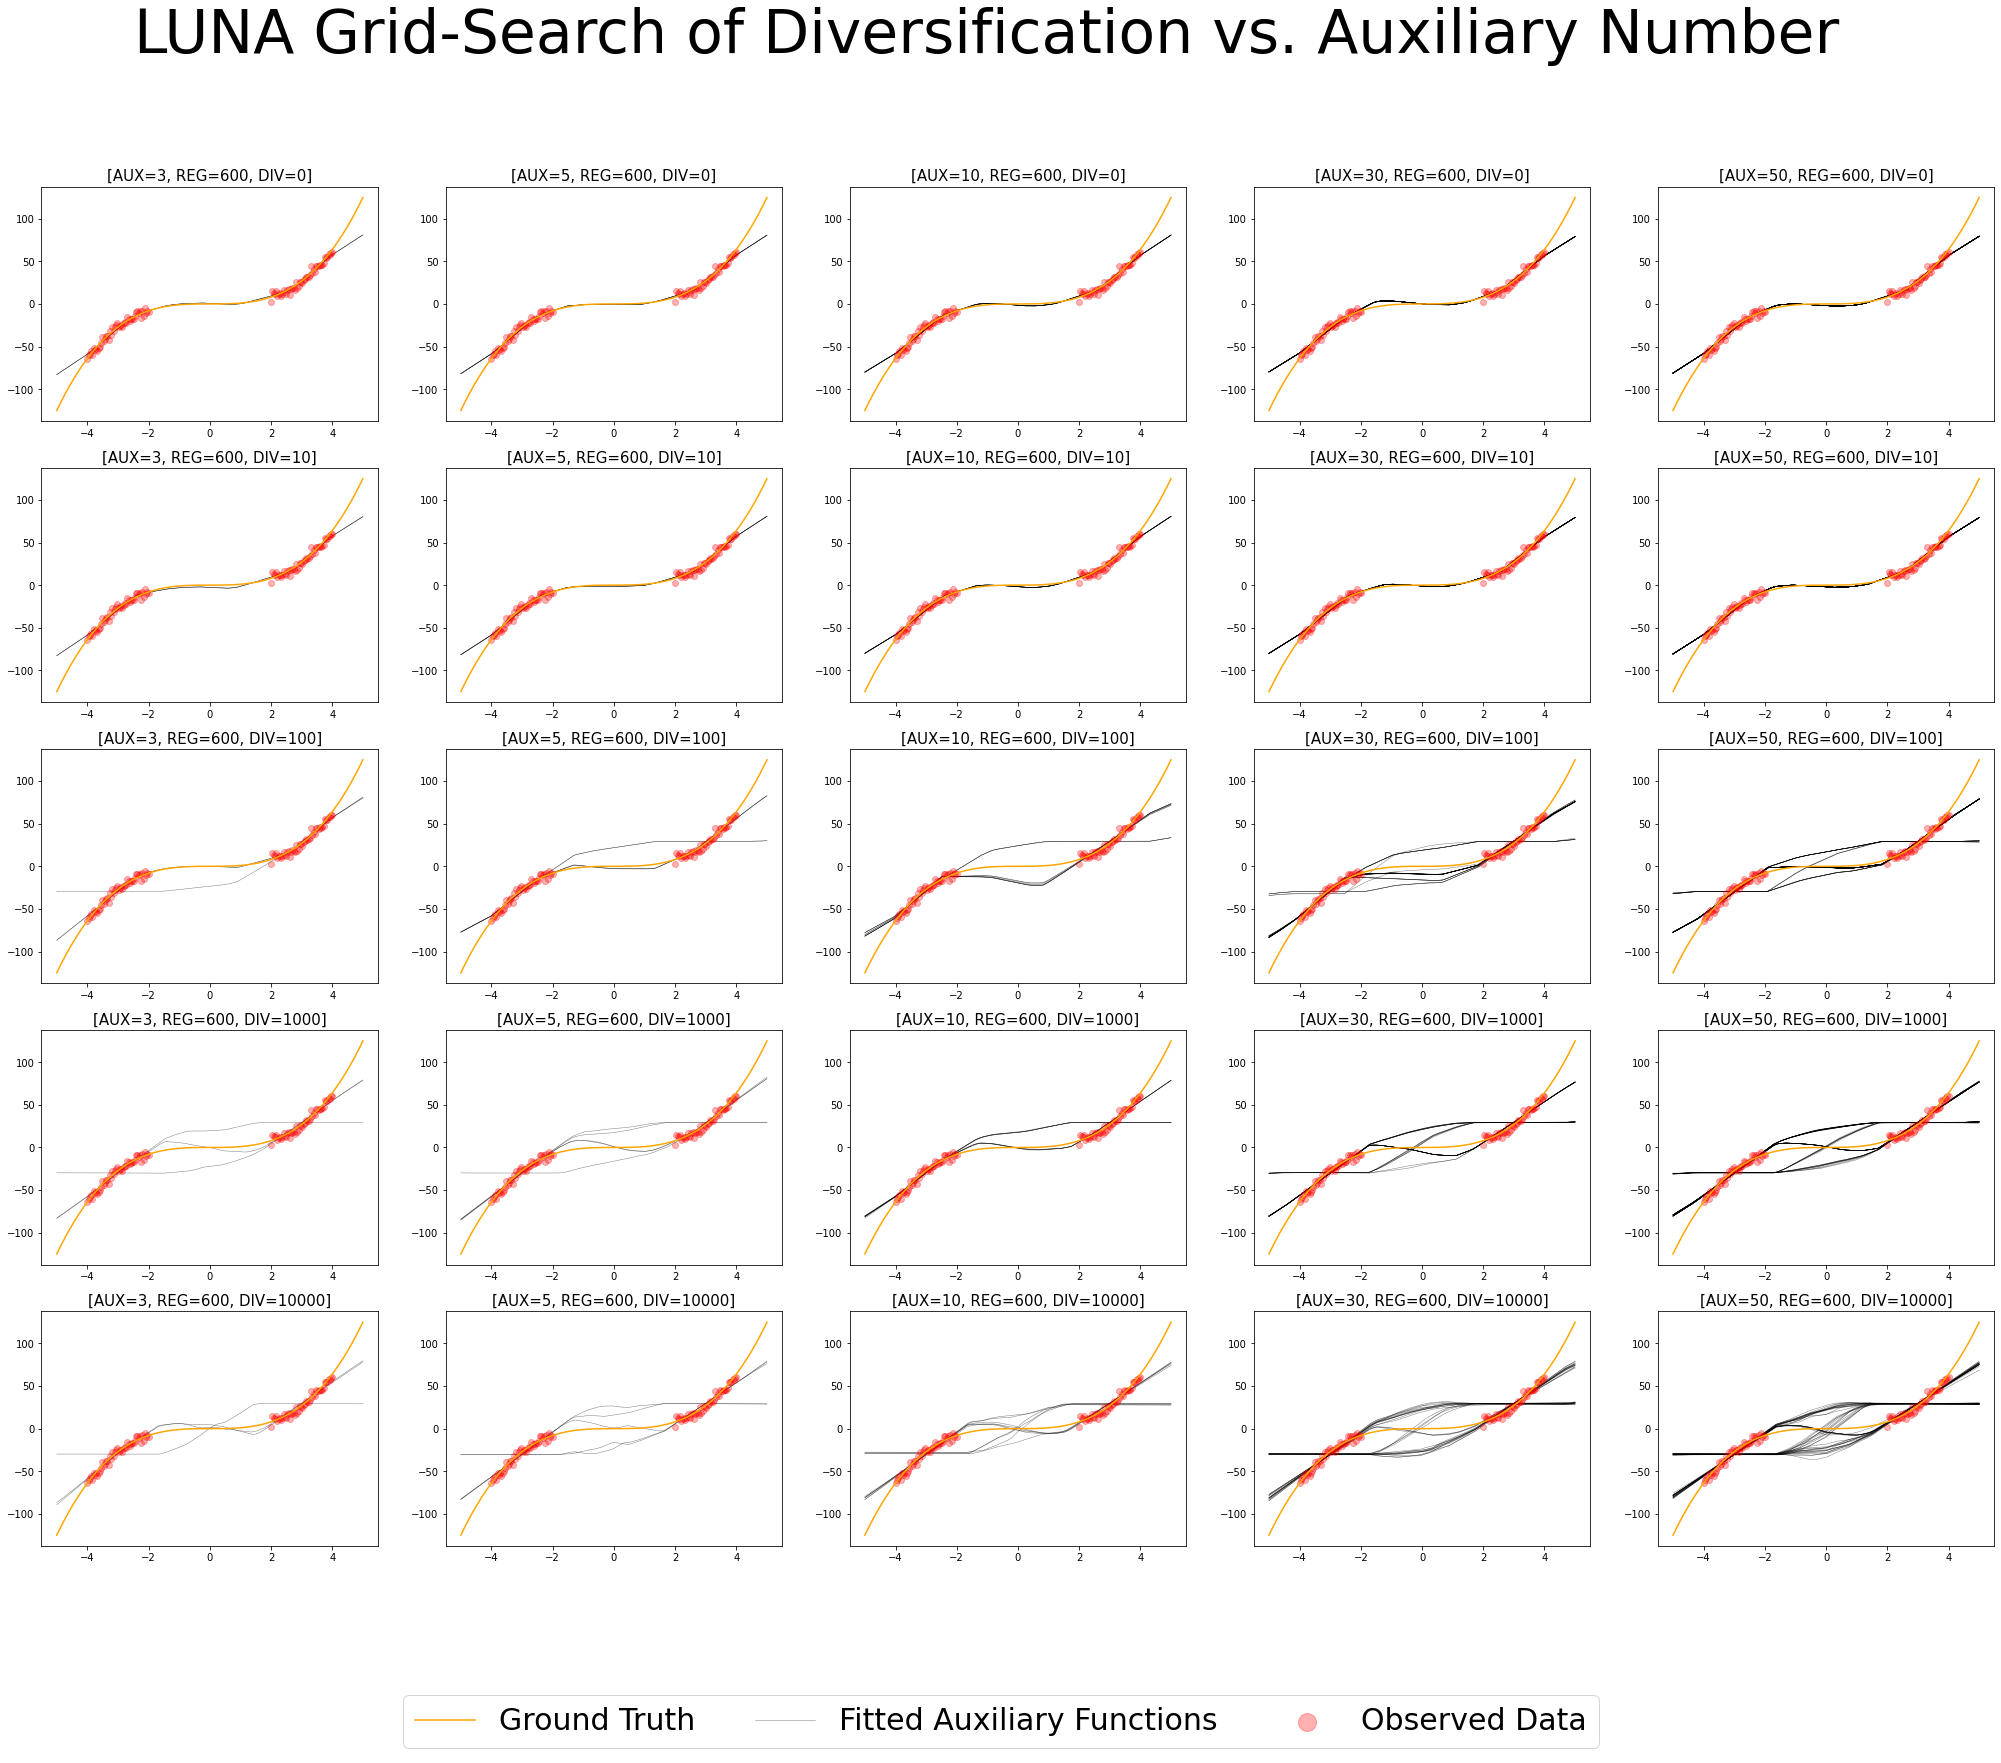

In [ ]:
fig, axes = plt.subplots(len(div_grid), len(aux_grid), figsize=(35, 25))
for i, ax in enumerate(axes.flat):
    luna = luna_list[i]
    y_pred = luna.forward(luna.weights, x_test)
    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], np.squeeze(y_pred).T[:,:1], color='black', linewidth=0.5, alpha=0.5, zorder=0, label="Fitted Auxiliary Functions")
    ax.plot(x_test[0,:], np.squeeze(y_pred).T[:,1:], color='black', linewidth=0.5, alpha=0.5, zorder=0)
    ax.set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]", fontsize=15)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=30, markerscale=3)
plt.suptitle("LUNA Grid-Search of Diversification vs. Auxiliary Number", fontsize=60)
plt.subplots_adjust(hspace=0.2)
plt.show()

## Plot prior samples

In [ ]:
prior_mean = 0; prior_var = 9; noise_var = 9

fig, axes = plt.subplots(len(div_grid), len(aux_grid), figsize=(30, 25))
for i, ax in enumerate(axes.flat):
    luna = luna_list[i]
    y_prior = luna.get_prior_preds(x_test, w_prior_mean = prior_mean, w_prior_cov=prior_var, noise_var=noise_var)
    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], y_prior.T[:,:1], color='tab:blue', alpha=0.1, label="Prior Model Samples")
    ax.plot(x_test[0,:], y_prior.T[:,1:], color='tab:blue', alpha=0.1)
    ax.set_ylim([-150, 150])
    ax.set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]", fontsize=15)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=30, markerscale=3)
plt.suptitle("LUNA Grid-Search of Diversification vs. Auxiliary Number", fontsize=60)
plt.subplots_adjust(hspace=0.2)
plt.show()

## Plot posterior samples

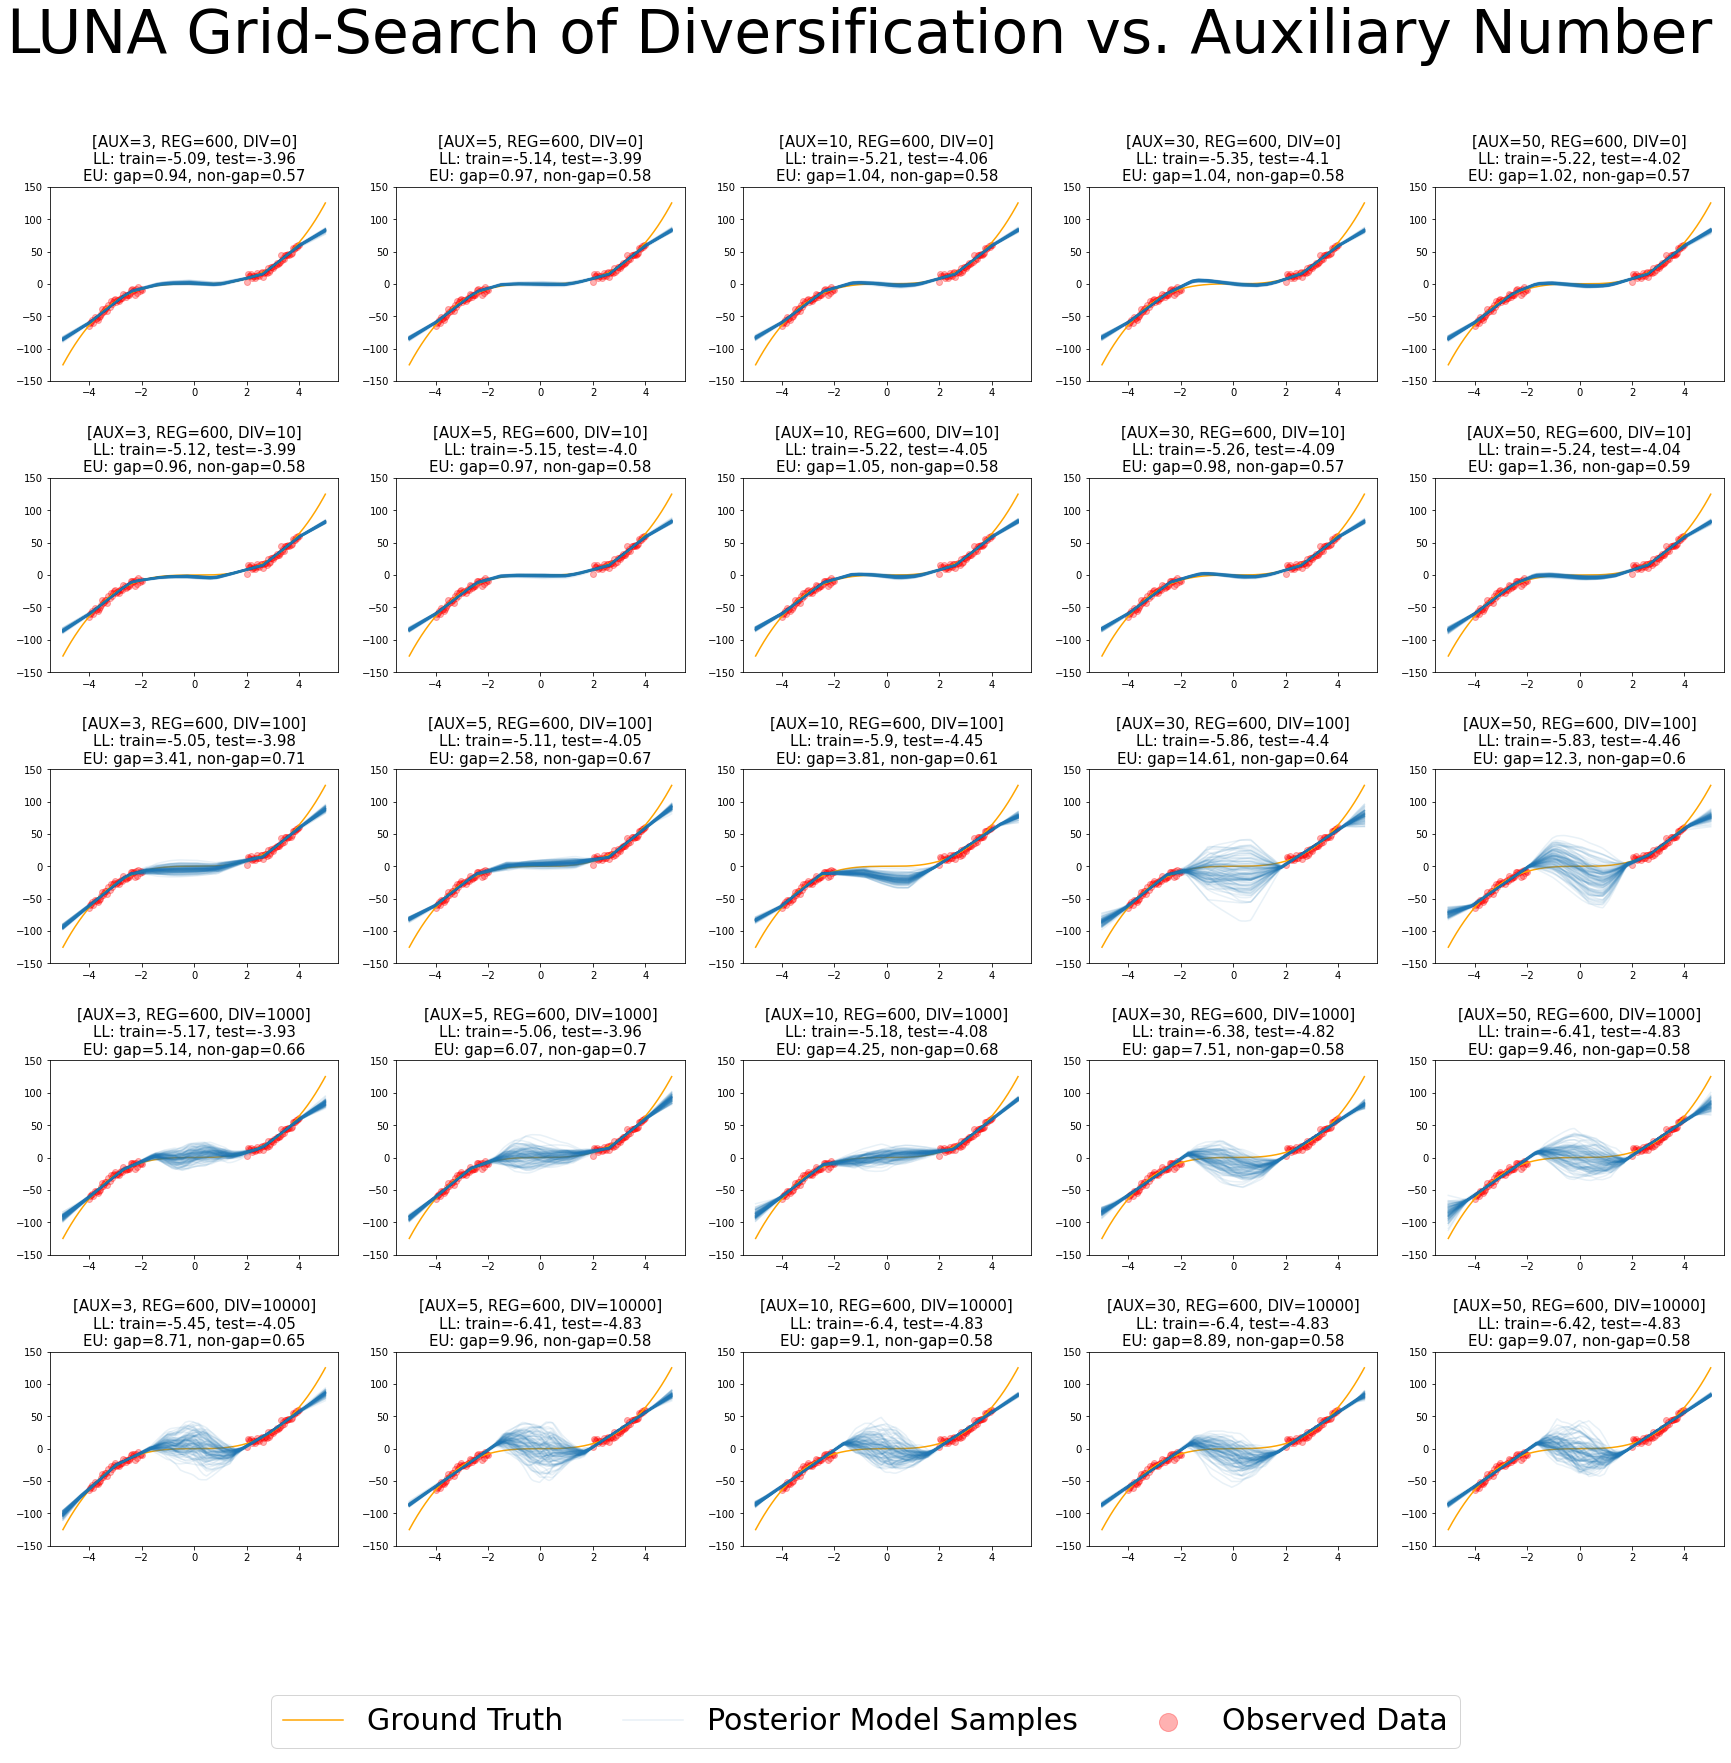

In [ ]:
nll_train_list_luna = []
nll_test_list_luna = []
eps_gap_list_luna = []
eps_non_gap_list_luna = []

fig, axes = plt.subplots(len(div_grid), len(aux_grid), figsize=(30, 25))
for i, ax in enumerate(axes.flat):
    luna = luna_list[i]
    y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], y_posterior.T[:,:1], color='tab:blue', alpha=0.1, label="Posterior Model Samples")
    ax.plot(x_test[0,:], y_posterior.T[:,1:], color='tab:blue', alpha=0.1)
    ax.set_ylim([-150, 150])

    y_posterior_train = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior_train_noise = y_posterior_train + np.random.normal(0, noise_var**0.5, size=y_posterior_train.shape)

    y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior_gap_noise = y_posterior_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_gap.shape)

    y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior_non_gap_noise = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_non_gap.shape)

    nll_train_list_luna.append(np.round(neg_log_likelihood(y_posterior_train_noise, y, noise_var), 2))
    nll_test_list_luna.append(np.round(neg_log_likelihood(y_posterior_non_gap_noise, y_test_non_gap, noise_var), 2))
    eps_gap_list_luna.append(np.round(epistemic_uncertainty(y_posterior_gap), 2))
    eps_non_gap_list_luna.append(np.round(epistemic_uncertainty(y_posterior_non_gap), 2))

    ax.set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]\nLL: train={-nll_train_list_luna[i]}, test={-nll_test_list_luna[i]}\nEU: gap={eps_gap_list_luna[i]}, non-gap={eps_non_gap_list_luna[i]}",fontsize=15)

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=30, markerscale=3)
plt.suptitle("LUNA Grid-Search of Diversification vs. Auxiliary Number", fontsize=60)
plt.subplots_adjust(hspace=0.5)
plt.show()

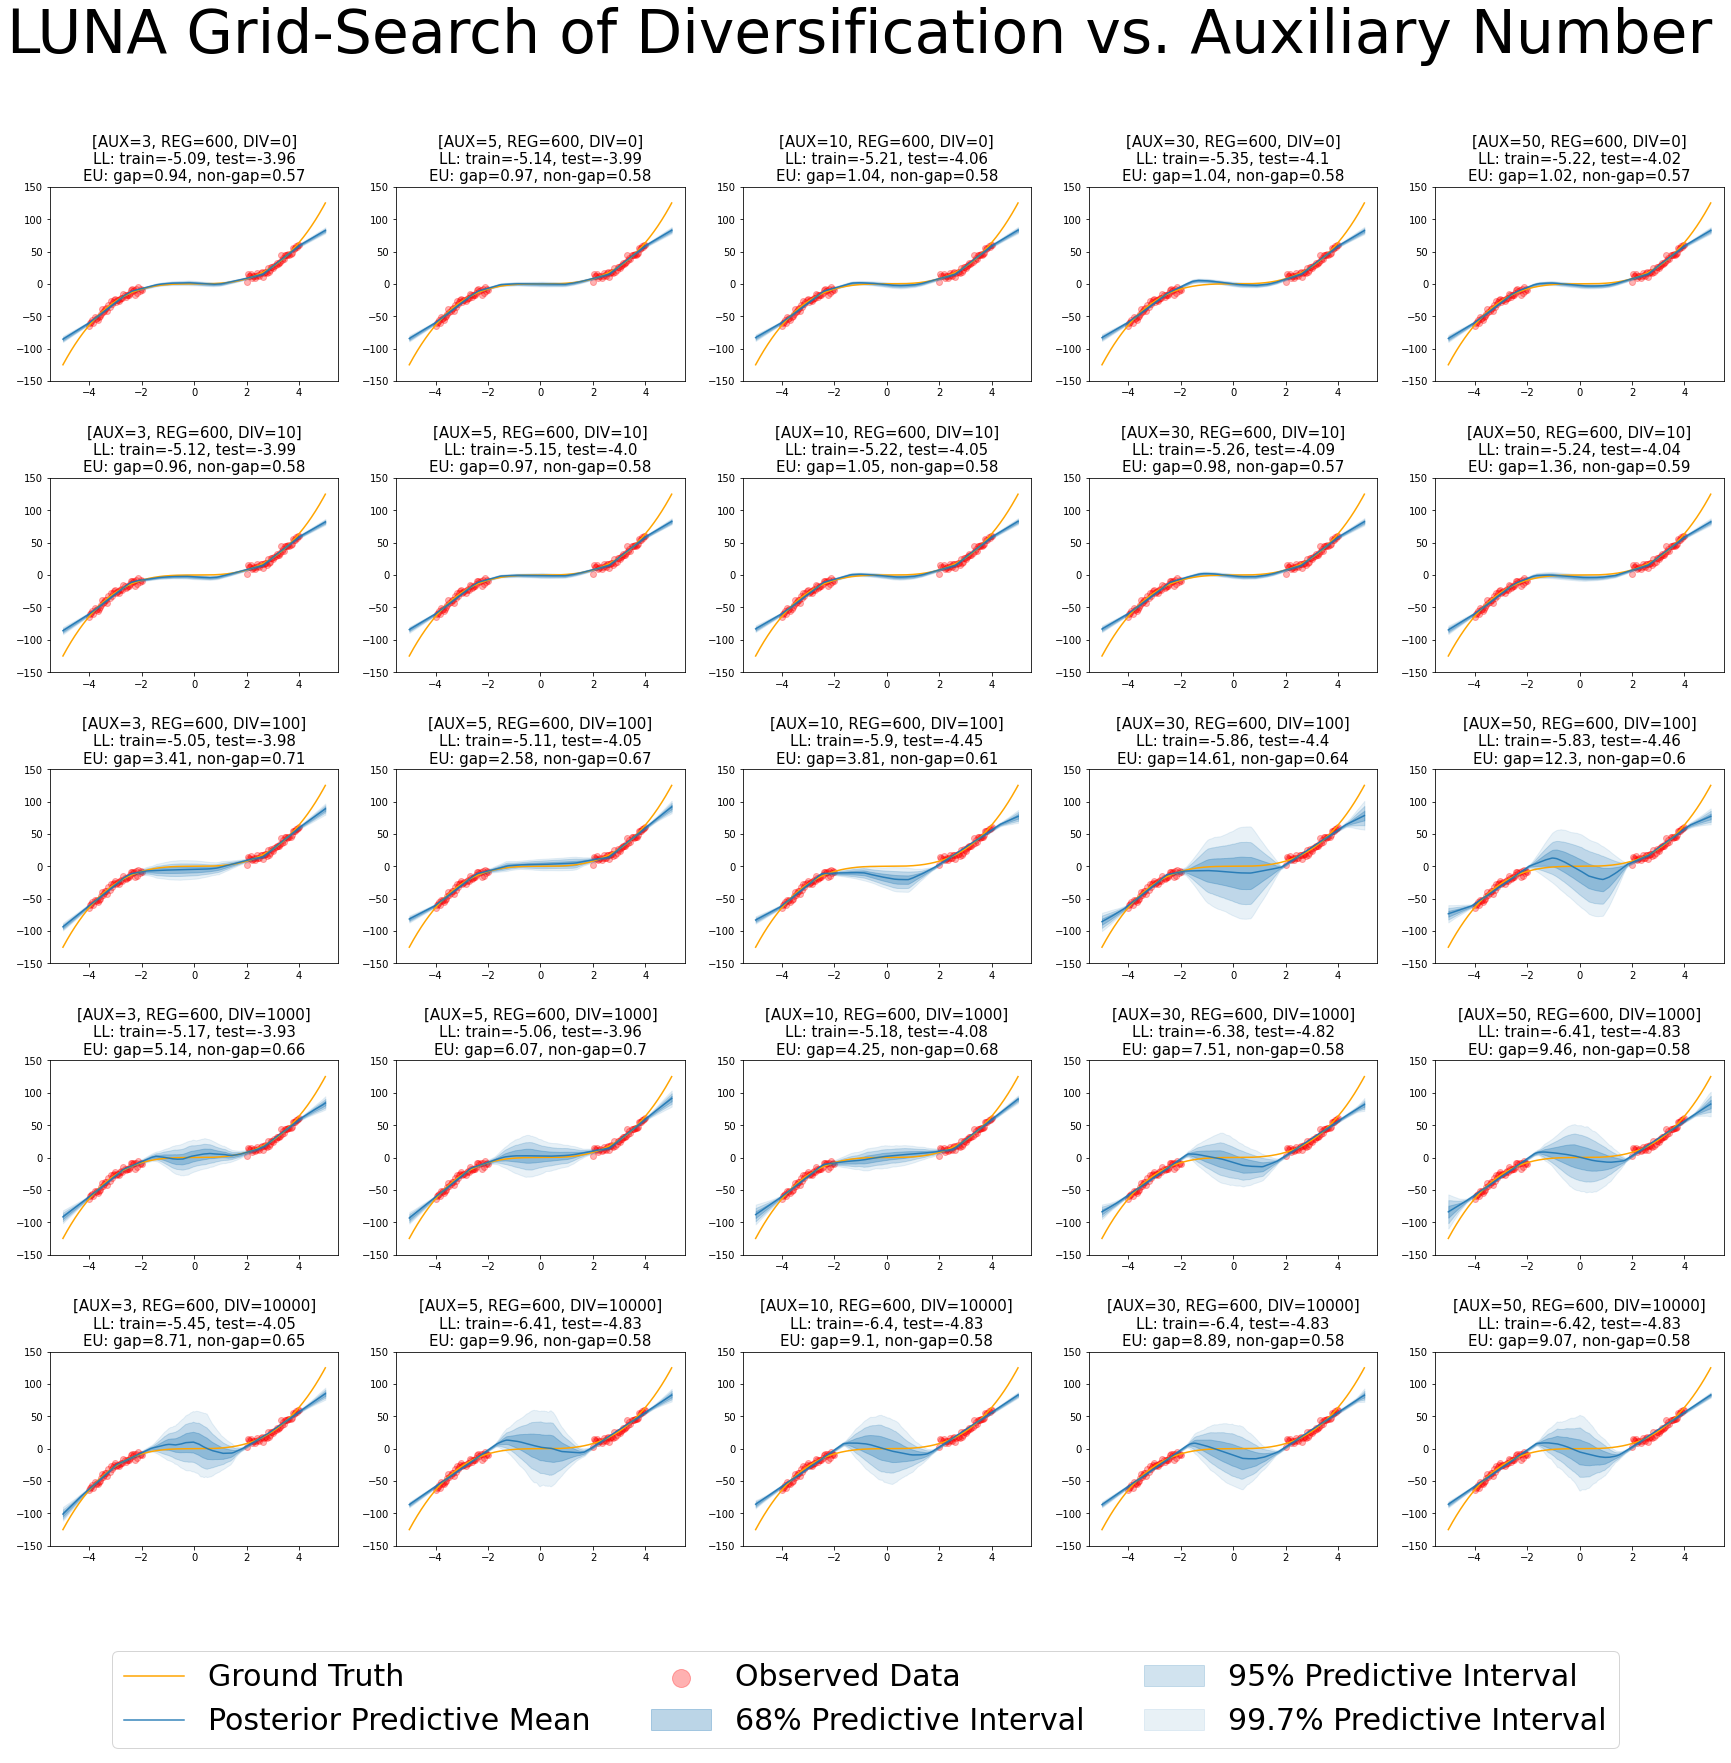

In [ ]:
fig, axes = plt.subplots(len(div_grid), len(aux_grid), figsize=(30, 25))
for i, ax in enumerate(axes.flat):
    luna = luna_list[i]
    y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)

    pp_upper = np.percentile(y_posterior, 97.5, axis=0)
    pp_lower = np.percentile(y_posterior, 2.5, axis=0)
    pp_upper2 = np.percentile(y_posterior, 84, axis=0)
    pp_lower2 = np.percentile(y_posterior, 16, axis=0)
    pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
    pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
    pp_mean = np.mean(y_posterior, axis=0)

    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
    ax.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label="68% Predictive Interval")
    ax.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label="95% Predictive Interval")
    ax.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label="99.7% Predictive Interval")

    ax.set_ylim([-150, 150])
    ax.set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]\nLL: train={-nll_train_list_luna[i]}, test={-nll_test_list_luna[i]}\nEU: gap={eps_gap_list_luna[i]}, non-gap={eps_non_gap_list_luna[i]}", fontsize=15)

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=30, markerscale=3)
plt.suptitle("LUNA Grid-Search of Diversification vs. Auxiliary Number", fontsize=60)
plt.subplots_adjust(hspace=0.5)
plt.show()

## Evaluate grid-search

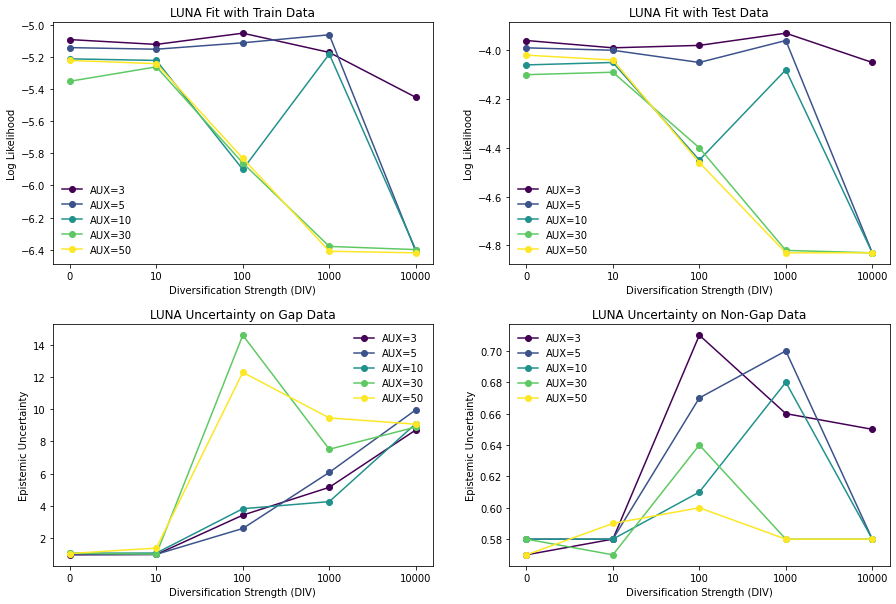

In [ ]:
cmap = plt.get_cmap('viridis', len(aux_grid))

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot NLL on train data
for idx, aux in enumerate(aux_grid):
    ax[0,0].plot(-np.array(nll_train_list_luna).reshape(len(div_grid), len(aux_grid)).T[idx,:], '-o', color=cmap(idx), label=f"AUX={aux}")
ax[0,0].set_xticks(range(len(div_grid)))
ax[0,0].set_xticklabels(div_grid)
ax[0,0].set_xlabel('Diversification Strength (DIV)')
ax[0,0].set_ylabel('Log Likelihood')
ax[0,0].set_title('LUNA Fit with Train Data')
ax[0,0].legend(frameon=False)

# Plot NLL on test data
for idx, aux in enumerate(aux_grid):
    ax[0,1].plot(-np.array(nll_test_list_luna).reshape(len(div_grid), len(aux_grid)).T[idx,:], '-o', color=cmap(idx), label=f"AUX={aux}")
ax[0,1].set_xticks(range(len(div_grid)))
ax[0,1].set_xticklabels(div_grid)
ax[0,1].set_xlabel('Diversification Strength (DIV)')
ax[0,1].set_ylabel('Log Likelihood')
ax[0,1].set_title('LUNA Fit with Test Data')
ax[0,1].legend(frameon=False)

# Plot EPS on gap data
for idx, aux in enumerate(aux_grid):
    ax[1,0].plot(np.array(eps_gap_list_luna).reshape(len(div_grid), len(aux_grid)).T[idx,:], '-o', color=cmap(idx), label=f"AUX={aux}")
ax[1,0].set_xticks(range(len(div_grid)))
ax[1,0].set_xticklabels(div_grid)
ax[1,0].set_xlabel('Diversification Strength (DIV)')
ax[1,0].set_ylabel('Epistemic Uncertainty')
ax[1,0].set_title('LUNA Uncertainty on Gap Data')
ax[1,0].legend(frameon=False)

# Plot EPS on non-gap data
for idx, aux in enumerate(aux_grid):
    ax[1,1].plot(np.array(eps_non_gap_list_luna).reshape(len(div_grid), len(aux_grid)).T[idx,:], '-o', color=cmap(idx), label=f"AUX={aux}")
ax[1,1].set_xticks(range(len(div_grid)))
ax[1,1].set_xticklabels(div_grid)
ax[1,1].set_xlabel('Diversification Strength (DIV)')
ax[1,1].set_ylabel('Epistemic Uncertainty')
ax[1,1].set_title('LUNA Uncertainty on Non-Gap Data')
ax[1,1].legend(frameon=False)

plt.subplots_adjust(hspace=0.25)
plt.show()

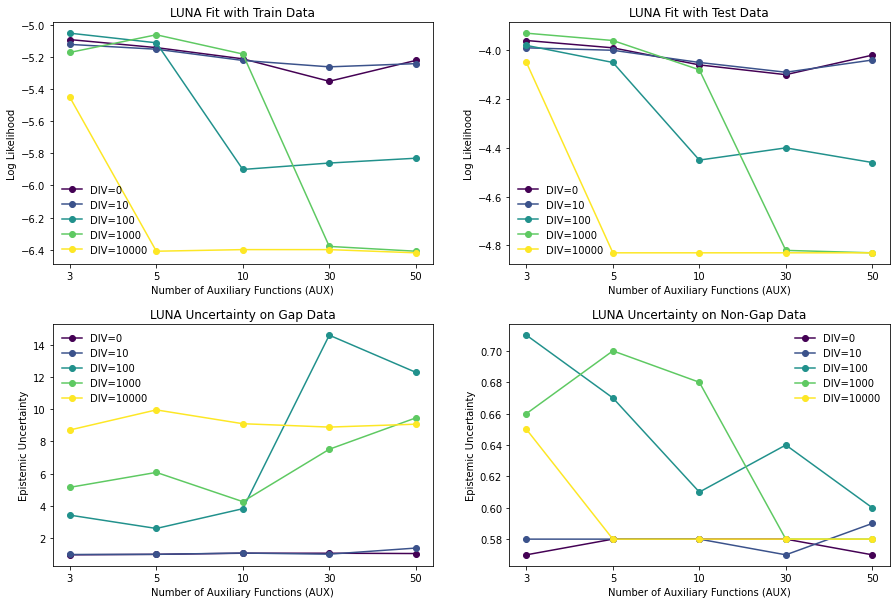

In [ ]:
cmap = plt.get_cmap('viridis', len(div_grid))

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot NLL on train data
for idx, div in enumerate(div_grid):
    ax[0,0].plot(-np.array(nll_train_list_luna).reshape(len(div_grid), len(aux_grid))[idx,:], '-o', color=cmap(idx), label=f"DIV={div}")
ax[0,0].set_xticks(range(len(aux_grid)))
ax[0,0].set_xticklabels(aux_grid)
ax[0,0].set_xlabel('Number of Auxiliary Functions (AUX)')
ax[0,0].set_ylabel('Log Likelihood')
ax[0,0].set_title('LUNA Fit with Train Data')
ax[0,0].legend(frameon=False)

# Plot NLL on test data
for idx, div in enumerate(div_grid):
    ax[0,1].plot(-np.array(nll_test_list_luna).reshape(len(div_grid), len(aux_grid))[idx,:], '-o', color=cmap(idx), label=f"DIV={div}")
ax[0,1].set_xticks(range(len(aux_grid)))
ax[0,1].set_xticklabels(aux_grid)
ax[0,1].set_xlabel('Number of Auxiliary Functions (AUX)')
ax[0,1].set_ylabel('Log Likelihood')
ax[0,1].set_title('LUNA Fit with Test Data')
ax[0,1].legend(frameon=False)

# Plot EPS on gap data
for idx, div in enumerate(div_grid):
    ax[1,0].plot(np.array(eps_gap_list_luna).reshape(len(div_grid), len(aux_grid))[idx,:], '-o', color=cmap(idx), label=f"DIV={div}")
ax[1,0].set_xticks(range(len(aux_grid)))
ax[1,0].set_xticklabels(aux_grid)
ax[1,0].set_xlabel('Number of Auxiliary Functions (AUX)')
ax[1,0].set_ylabel('Epistemic Uncertainty')
ax[1,0].set_title('LUNA Uncertainty on Gap Data')
ax[1,0].legend(frameon=False)

# Plot EPS on non-gap data
for idx, div in enumerate(div_grid):
    ax[1,1].plot(np.array(eps_non_gap_list_luna).reshape(len(div_grid), len(aux_grid))[idx,:], '-o', color=cmap(idx), label=f"DIV={div}")
ax[1,1].set_xticks(range(len(aux_grid)))
ax[1,1].set_xticklabels(aux_grid)
ax[1,1].set_xlabel('Number of Auxiliary Functions (AUX)')
ax[1,1].set_ylabel('Epistemic Uncertainty')
ax[1,1].set_title('LUNA Uncertainty on Non-Gap Data')
ax[1,1].legend(frameon=False)

plt.subplots_adjust(hspace=0.25)
plt.show()

## Takeaways

Even with a small number of auxiliary functions, we can obtain considerably large epistemic uncertainty if diversification strength is large enough (relative to regularization strength). However, large diversification strength pushes auxiliary functions “away” from one another (to make their gradients orthogonal), which results in poor fit with the observed data (i.e. lower log-likelihood).

Increase in the number of auxiliary functions seems to mediate this tradeoff between fit with the observed data and desirable epistemic uncertainty: by increasing the number of auxiliary functions, we can achieve ideal epistemic uncertainty at much *lower* diversification strength, which means less sacrifice of fit with the observed data. However, LUNA with more auxiliary functions takes longer to train, so there is still a tradeoff.

In sum, LUNA helps to overcome “collapse” of epistemic uncertainty in the face of regularization by introducing diversification of auxiliary functions. This, however, comes at the cost of fit with the observed data: greater diversification, although achieving good epistemic uncertainty under regularization, deteriorates the model’s fit with the observed data. This can be overcome by using more auxiliary functions at weaker diversification, but LUNA with more auxiliary functions takes longer to train.


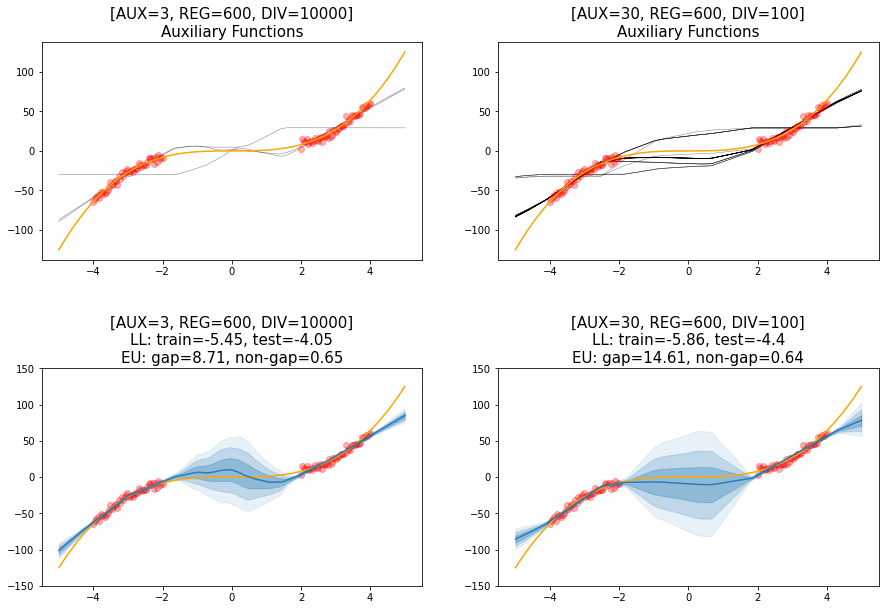

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for a, i in enumerate([-5,-12]):

    luna = luna_list[i]

    y_pred = luna.forward(luna.weights, x_test)
    ax[0,a].scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax[0,a].plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
    ax[0,a].plot(x_test[0,:], np.squeeze(y_pred).T[:,:1], color='black', linewidth=0.5, alpha=0.5, zorder=0, label="Fitted Auxiliary Functions")
    ax[0,a].plot(x_test[0,:], np.squeeze(y_pred).T[:,1:], color='black', linewidth=0.5, alpha=0.5, zorder=0)
    ax[0,a].set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]\nAuxiliary Functions", fontsize=15)

    y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    pp_upper = np.percentile(y_posterior, 97.5, axis=0)
    pp_lower = np.percentile(y_posterior, 2.5, axis=0)
    pp_upper2 = np.percentile(y_posterior, 84, axis=0)
    pp_lower2 = np.percentile(y_posterior, 16, axis=0)
    pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
    pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
    pp_mean = np.mean(y_posterior, axis=0)
    ax[1,a].scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax[1,a].plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax[1,a].plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
    ax[1,a].fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label="68% Predictive Interval")
    ax[1,a].fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label="95% Predictive Interval")
    ax[1,a].fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label="99.7% Predictive Interval")
    ax[1,a].set_ylim([-150, 150])
    ax[1,a].set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]\nLL: train={-nll_train_list_luna[i]}, test={-nll_test_list_luna[i]}\nEU: gap={eps_gap_list_luna[i]}, non-gap={eps_non_gap_list_luna[i]}", fontsize=15)

handles, labels = ax[0,1].get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5)
plt.show()

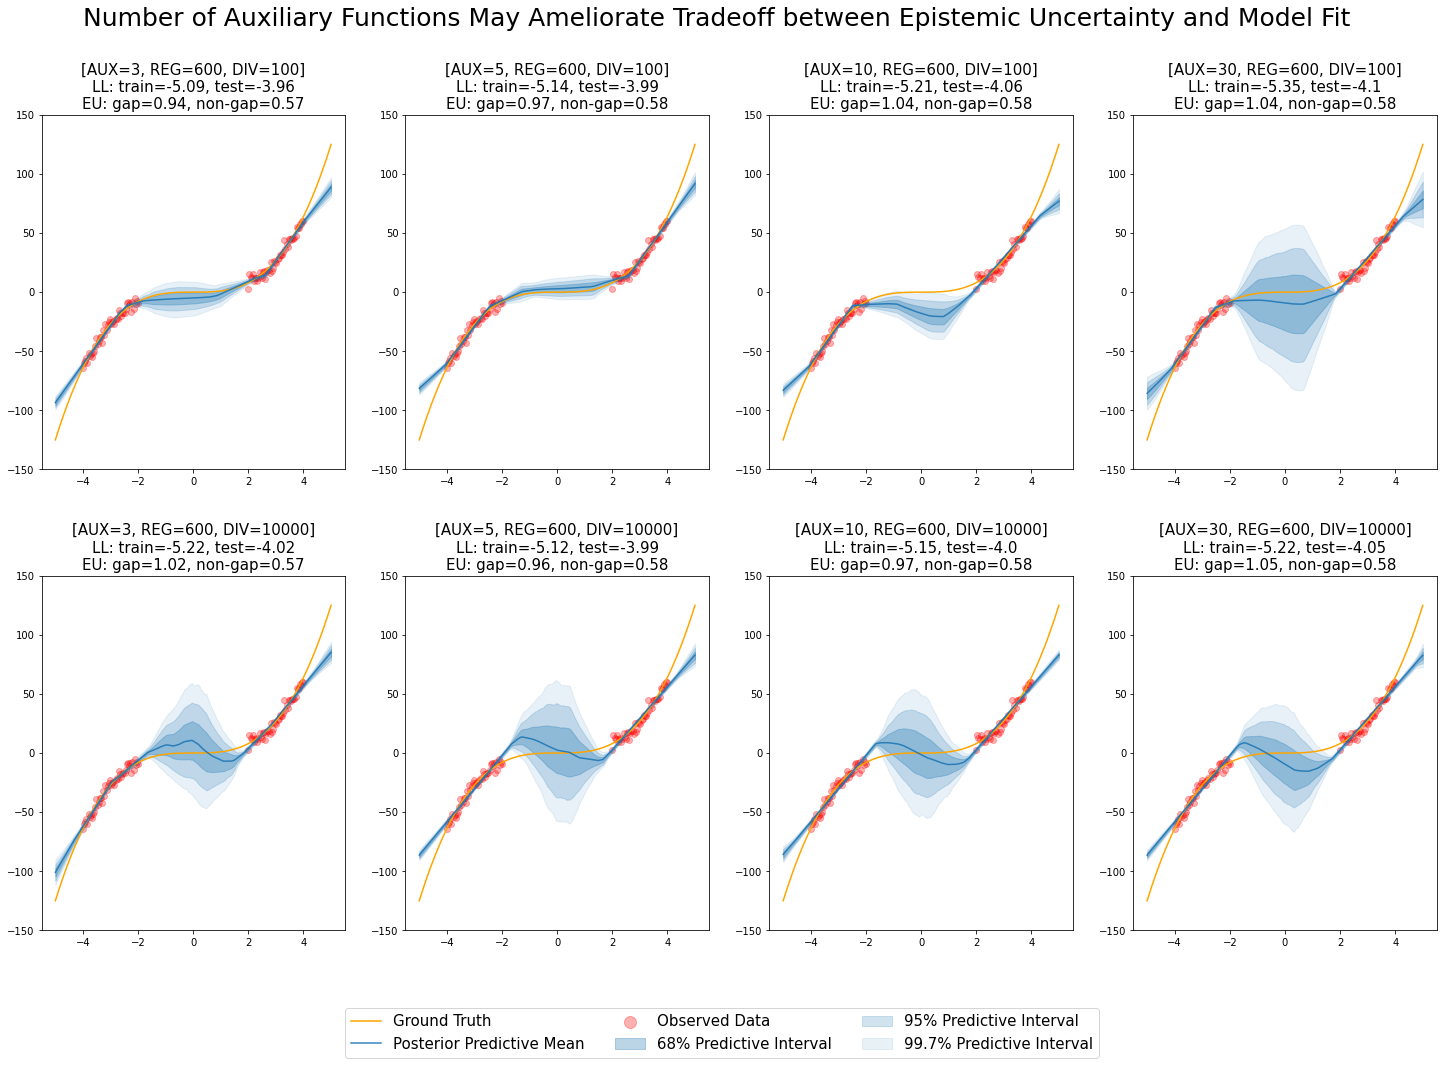

In [ ]:
luna_select = luna_list[-15:-11] + luna_list[-5:-1]

fig, axes = plt.subplots(2, 4, figsize=(25, 15))
for i, ax in enumerate(axes.flat):
    luna = luna_select[i]
    y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)

    pp_upper = np.percentile(y_posterior, 97.5, axis=0)
    pp_lower = np.percentile(y_posterior, 2.5, axis=0)
    pp_upper2 = np.percentile(y_posterior, 84, axis=0)
    pp_lower2 = np.percentile(y_posterior, 16, axis=0)
    pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
    pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
    pp_mean = np.mean(y_posterior, axis=0)

    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
    ax.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label="68% Predictive Interval")
    ax.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label="95% Predictive Interval")
    ax.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label="99.7% Predictive Interval")

    ax.set_ylim([-150, 150])
    ax.set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]\nLL: train={-nll_train_list_luna[i]}, test={-nll_test_list_luna[i]}\nEU: gap={eps_gap_list_luna[i]}, non-gap={eps_non_gap_list_luna[i]}", fontsize=15)

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=15, markerscale=2)
plt.suptitle("Number of Auxiliary Functions May Ameliorate Tradeoff between Epistemic Uncertainty and Model Fit", fontsize=25)
plt.subplots_adjust(hspace=0.3)
# plt.savefig(path.join(ROOT_PATH, "images", "PPI_LUNA_reg600_steps5000.png"), dpi=150)
plt.show()